<center><img src=https://raw.githubusercontent.com/feast-dev/feast/master/docs/assets/feast_logo.png width=400/></center>

# Credit Risk Data Preparation

Predicting credit risk is an important task for financial institutions. If a bank can accurately determine the probability that a borrower will pay back a future loan, then they can make better decisions on loan terms and approvals. Getting credit risk right is critical to offering good financial services, and getting credit risk wrong could mean going out of business.

AI models have played a central role in modern credit risk assessment systems. In this example, we develop a credit risk model to predict whether a future loan will be good or bad, given some context data (presumably supplied from the loan application). We use the modeling process to demonstrate how Feast can be used to facilitate the serving of data for training and inference use-cases.

In this notebook, we prepare the data.

### Setup

*The following code assumes that you have read the example README.md file, and that you have setup an environment where the code can be run. Please make sure you have addressed the prerequisite needs.*

In [1]:
# Import Python libraries
import os
import random
import warnings
import datetime as dt
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
# suppress warning messages for example flow (don't run if you want to see warnings)
warnings.filterwarnings('ignore')

### Pull the Data

The data we will use to train the model is from the [OpenML](https://www.openml.org/) dataset [credit-g](https://www.openml.org/search?type=data&sort=runs&status=active&id=31), obtained from a 1994 German study. More details on the data can be found in the `DESC` attribute and `details` map (see below).

In [3]:
data = fetch_openml(name="credit-g", version=1, parser='auto')

In [4]:
print(data.DESCR)

**Author**: Dr. Hans Hofmann  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

**German Credit dataset**  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
Good  Bad (predicted)  
Good   0    1   (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).  

### Attribute description  

1. Status of existing checking account, in Deutsche Mark.  
2. Duration in months  
3. Credit history (credits taken, paid back duly, delays, critical accounts)  
4. Purpose of the credit (car, television,...)  
5. Credit amount  
6. Status of savings account/bonds, in Deutsche Mark.  
7. Present employment, in number of years.  
8. Installment rate in percentage of disposable income  
9. Perso

In [5]:
print("Original data url: ".ljust(20), data.details["original_data_url"])
print("Paper url: ".ljust(20), data.details["paper_url"])

Original data url:   https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
Paper url:           https://dl.acm.org/doi/abs/10.1145/967900.968104


### High-Level Data Inspection

Let's inspect the data to see high level details like data types and size. We also want to make sure there are no glaring issues (like a large number of null values).

In [6]:
df = data.frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

We see that there are 21 columns, each with 1000 non-null values. The first 20 columns are contextual fields with `Dtype` of `category` or `int64`, while the last field is actually the target variable, `class`, which we wish to predict. 

From the description (above), the `class` tells us whether a loan to a customer was "good" or "bad". We are anticipating that patterns in the contextual data, as well as their relationship to the class outcomes, can give insight into loan classification. In the following notebooks, we will build a loan classification model that seeks to encode these patterns and relationships in its weights, such that given a new loan application (context data), the model can predict whether the loan (if approved) will be good or bad in the future.

### Split the Data

Next, we split the data into a `train` and `test` set, which we will use to train and then test a model. The test set will allow us to more accurately assess the model's performance on data that it has not seen during the training phase.

In [7]:
# Split data into train and test datasets
# We use arbitrarily chosen random seed = 142 for some reproducibility
SEED = 142
train, test = train_test_split(df, test_size=0.2, random_state=SEED)

### Exploratory Data Analysis

Before building a model, a data scientist needs to gain understanding of the data to make sure it meets important statistical assumptions, and to identify potential opportunities and issues. As the purpose of this particular example is to show Feast working with, we will take the view of a data scientist looking to build a quick baseline model to establish some low-end metrics.

Note that this data set is very "clean", as it has already been prepared. In real-life, production credit risk data can be much more complex, and have many issues that need to be understood and addressed before modeling.

Let's look at counts for the target variable `class`, which tells us whether a (historical) loan was good or bad. We can see that there were many more good loans than bad, making the dataset imbalanced.

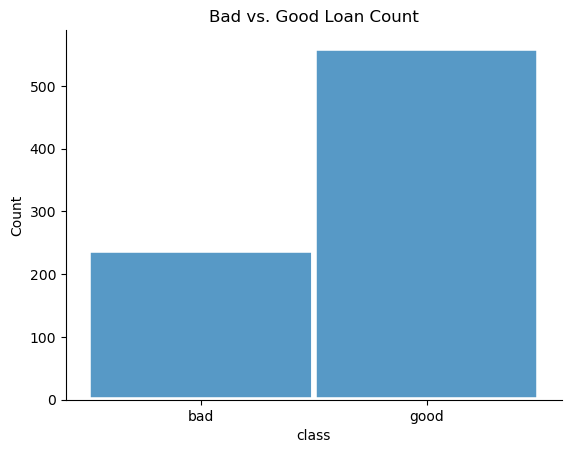

In [8]:
# plot the target variable "class"
p = sns.histplot(train["class"], ec="w", lw=4)
_ = p.set_title("Bad vs. Good Loan Count")
_ = p.spines["top"].set_visible(False)
_ = p.spines["right"].set_visible(False)

Now, view the first few records of the context data.

In [10]:
# View first records in training data (transposed)
train.head().T

,18,764,504,454,453
checking_status,0<=X<200,no checking,<0,<0,no checking
duration,24,24,24,24,24
credit_history,existing paid,critical/other existing credit,existing paid,existing paid,existing paid
purpose,used car,new car,new car,new car,used car
credit_amount,12579,2463,1207,4817,2670
savings_status,<100,100<=X<500,<100,<100,<100
employment,>=7,4<=X<7,<1,4<=X<7,>=7
installment_commitment,4,4,4,2,4
personal_status,female div/dep/mar,male mar/wid,female div/dep/mar,male single,male single
other_parties,none,none,none,co applicant,none


### Feature Engineering

Once data columns have been prepared so that they can be used to train an AI model, it is common to refer to them as "features". The process of preparing features is referred to as "feature engineering".

As we are creating a rather simple baseline model, we will ignore the categorical columns in favor of simplicity, noting that we are potentially leaving a lot of useful information out. 

In [11]:
# Filter on numeric feature columns
train_num = train.loc[
    :, 
    (train.dtypes == "int64")
].astype(float)
test_num = test.loc[
    :,
    (test.dtypes == "int64")
].astype(float)

We'll also split out the target (label) data, as this generally is recorded separately from the contextual data in real-life, and it is often worked with separately in AI modeling. In the process, let's also engineer `class` into a numerical column, from categorical ("good" | "bad") to float (1.0 | 0.0).

In [12]:
# Make "class" target variable numeric
train_y = (train["class"] == "good").astype(float)
test_y = (test["class"] == "good").astype(float)

### Additional Data Preparation (For Demonstrating Feast)

At this point, it's important to bring up that Feast was developed primarily to work with production data. Feast requires datasets to have IDs and timestamps, which it uses in joins.

In a real loan application scenario, the application fields (in a database) would be associated with a timestamp, while the actual loan outcome (label) would be determined much later and recorded separately with a different timestamp.

In order to demonstrate Feast capabilities, such as point-in-time joins, we will mock IDs and timestamps for this data. For IDs, we will use the original dataframe index values. For the timestamps, we will generate random values between "Tue Sep 24 12:00:00 2024" and "Wed Oct  9 12:00:00 2024".

(Note that we do not set the seed here, so that we can get different timestamps in the range; therefore, you will see different timestamps when you run the following code.)

In [13]:
# Make index into "ID" column
train_num = train_num.reset_index(names=["ID"])
test_num = test_num.reset_index(names=["ID"])

In [14]:
# Add mock timestamps
time_format = "%a %b %d %H:%M:%S %Y"
date = dt.datetime.strptime("Wed Oct  9 12:00:00 2023", time_format)
end = int(date.timestamp())
start = int((date - dt.timedelta(days=15)).timestamp())  # 'Tue Sep 24 12:00:00 2023'

def make_tstamp(start, end):
    dtime = dt.datetime.fromtimestamp(random.randint(start, end)).ctime()
    return dtime
    
train_num["application_timestamp"] = pd.to_datetime([
    make_tstamp(start, end) for _ in range(0, len(train_num))
])
test_num["application_timestamp"] = pd.to_datetime([
    make_tstamp(start, end) for _ in range(0, len(test_num))
])


Let's check that the newly created "ID" and "application_timestamp" fields were created as expected.

In [15]:
# Check numerical features (first few records)
train_num.head()

,ID,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,application_timestamp
0,18,24.0,12579.0,4.0,2.0,44.0,1.0,1.0,2023-10-04 11:18:21
1,764,24.0,2463.0,4.0,3.0,27.0,2.0,1.0,2023-10-05 07:35:12
2,504,24.0,1207.0,4.0,4.0,24.0,1.0,1.0,2023-10-07 04:44:01
3,454,24.0,4817.0,2.0,3.0,31.0,1.0,1.0,2023-09-25 01:35:05
4,453,24.0,2670.0,4.0,4.0,35.0,1.0,1.0,2023-09-25 11:41:04


We'll also generate counterpart IDs and timestamps on the label data. To mimic real-life data, let's add a variable lag from the application timestamp of 30 to 90 days.

In [16]:
# Cast as dataframe and create ID field
train_y = train_y.to_frame().reset_index(names=["ID"])
test_y = test_y.to_frame().reset_index(names=["ID"])

In [17]:
# Add (lagged) label timestamps (30 to 90 days)
def create_lagged_tstamp(tstamp):
    lagged_tstamp = (
        # dt.datetime.strptime(tstamp, time_format)
        tstamp
        + dt.timedelta(days=random.randint(30,90), hours=random.randint(0,24))
    ).ctime()
    return lagged_tstamp
    
train_y["outcome_timestamp"] = pd.to_datetime(train_num.application_timestamp.apply(create_lagged_tstamp))
test_y["outcome_timestamp"] = pd.to_datetime(test_num.application_timestamp.apply(create_lagged_tstamp))

In [18]:
train_y.head()

,ID,class,outcome_timestamp
0,18,0.0,2023-11-15 16:18:21
1,764,1.0,2023-12-20 14:35:12
2,504,0.0,2023-12-12 04:44:01
3,454,0.0,2023-11-04 19:35:05
4,453,1.0,2023-10-29 09:41:04


To verify that we have introduced a lag for the class outcome, check the `outcome timestamp` for the 5 records above against the `application_timestamp` further up. You should see a difference of 30 to 90 days.

### Save Datasets

Now that we have our features and target data prepared, let's save it to local parquet files in the `data` directory (parquet is one of the file formats supported by Feast). 

One more step we will add is splitting the context data columnwise and saving it in two files. This step is contrived--we don't usually split data when we don't need to--but it will allow us to demonstrate later how Feast can easily join datasets (a common need in Data Science projects).

In [19]:
# Create the data directory if it doesn't exist
os.makedirs("Feature_Store/data", exist_ok=True)

# Split and save data
a_cols = ['ID', 'duration', 'credit_amount', 'installment_commitment', 'application_timestamp']
b_cols = ['ID', 'residence_since', 'age', 'existing_credits', 'num_dependents','application_timestamp']

train_num[a_cols].to_parquet("Feature_Store/data/train_a.parquet", engine="pyarrow")
train_num[b_cols].to_parquet("Feature_Store/data/train_b.parquet", engine="pyarrow")
test_num.to_parquet("Feature_Store/data/test.parquet", engine="pyarrow")

train_y.to_parquet("Feature_Store/data/train_y.parquet", engine="pyarrow")
test_y.to_parquet("Feature_Store/data/test_y.parquet", engine="pyarrow")

We have saved the following files to the `Feature_Store/data` directory: 
- `train_a.parquet` (training data, a columns)
- `train_b.parquet` (training data, b columns)
- `train_y.parquet` (training outcomes)
- `test.parquet` (test data)
- `test_y.parquet` (test outcomes)

With the feature data prepared, we are ready to setup and deploy the feature store. 

Continue with the [02_Credit_Risk_Model_Training.ipynb](02_Credit_Risk_Model_Training.ipynb) notebook.